In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.audio.audio import TrialAudio, VocalicsComponentAudio
from coordination.component.speech.vocalics_component import SegmentationMethod, VocalicsComponent
from coordination.entity.trial import Trial
from coordination.inference.vocalics import DiscreteCoordinationInferenceFromVocalics, ContinuousCoordinationInferenceFromVocalics
from coordination.plot.coordination import add_discrete_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features
from coordination.report.coordination_abrupt_change_report import CoordinationAbruptChangeReport

# Trial 745

We use post processed trial data. To generate this data, execute the script `coordination/scripts/parse_and_save_single_metadata_file.py`.

In [3]:
# Constants
NUM_TIME_STEPS = 17 * 60 #(17 minutes of mission in seconds)
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant
NUM_FEATURES = 2 # Pitch and Intensity

# Common parameters
MEAN_PRIOR_A = np.zeros(NUM_FEATURES)
MEAN_PRIOR_B = np.zeros(NUM_FEATURES)
STD_PRIOR_A = np.ones(NUM_FEATURES)
STD_PRIOR_B = np.ones(NUM_FEATURES)
ANTIPHASE_FUNCTION = lambda x, s: -x if s == 0 else x
ANYPHASE_FUNCTION = lambda x, s: np.abs(x)

# Parameters of the discrete model
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0 # The process starts with no coordination
STD_UNCOORDINATED_A = np.ones(NUM_FEATURES)
STD_UNCOORDINATED_B = np.ones(NUM_FEATURES)
STD_COORDINATED_A = np.ones(NUM_FEATURES)
STD_COORDINATED_B = np.ones(NUM_FEATURES)

# Parameters of the continuous model
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 0 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts by a little
STD_COUPLING_A = np.ones(NUM_FEATURES)
STD_COUPLING_B = np.ones(NUM_FEATURES)

## Vocalic Features

Utterance starting at 2022-06-14T22:43:54.542990+00:00 and ending 
                    at 2022-06-14T22:43:54.354299+00:00 is short and does not have any vocalics. Text:  all right
Utterance starting at 2022-06-14T22:51:21.956330+00:00 and ending 
                    at 2022-06-14T22:51:21.595633+00:00 is short and does not have any vocalics. Text:  okay
Utterance starting at 2022-06-14T22:50:47.542990+00:00 and ending 
                    at 2022-06-14T22:50:47.554299+00:00 is short and does not have any vocalics. Text:  yes you are


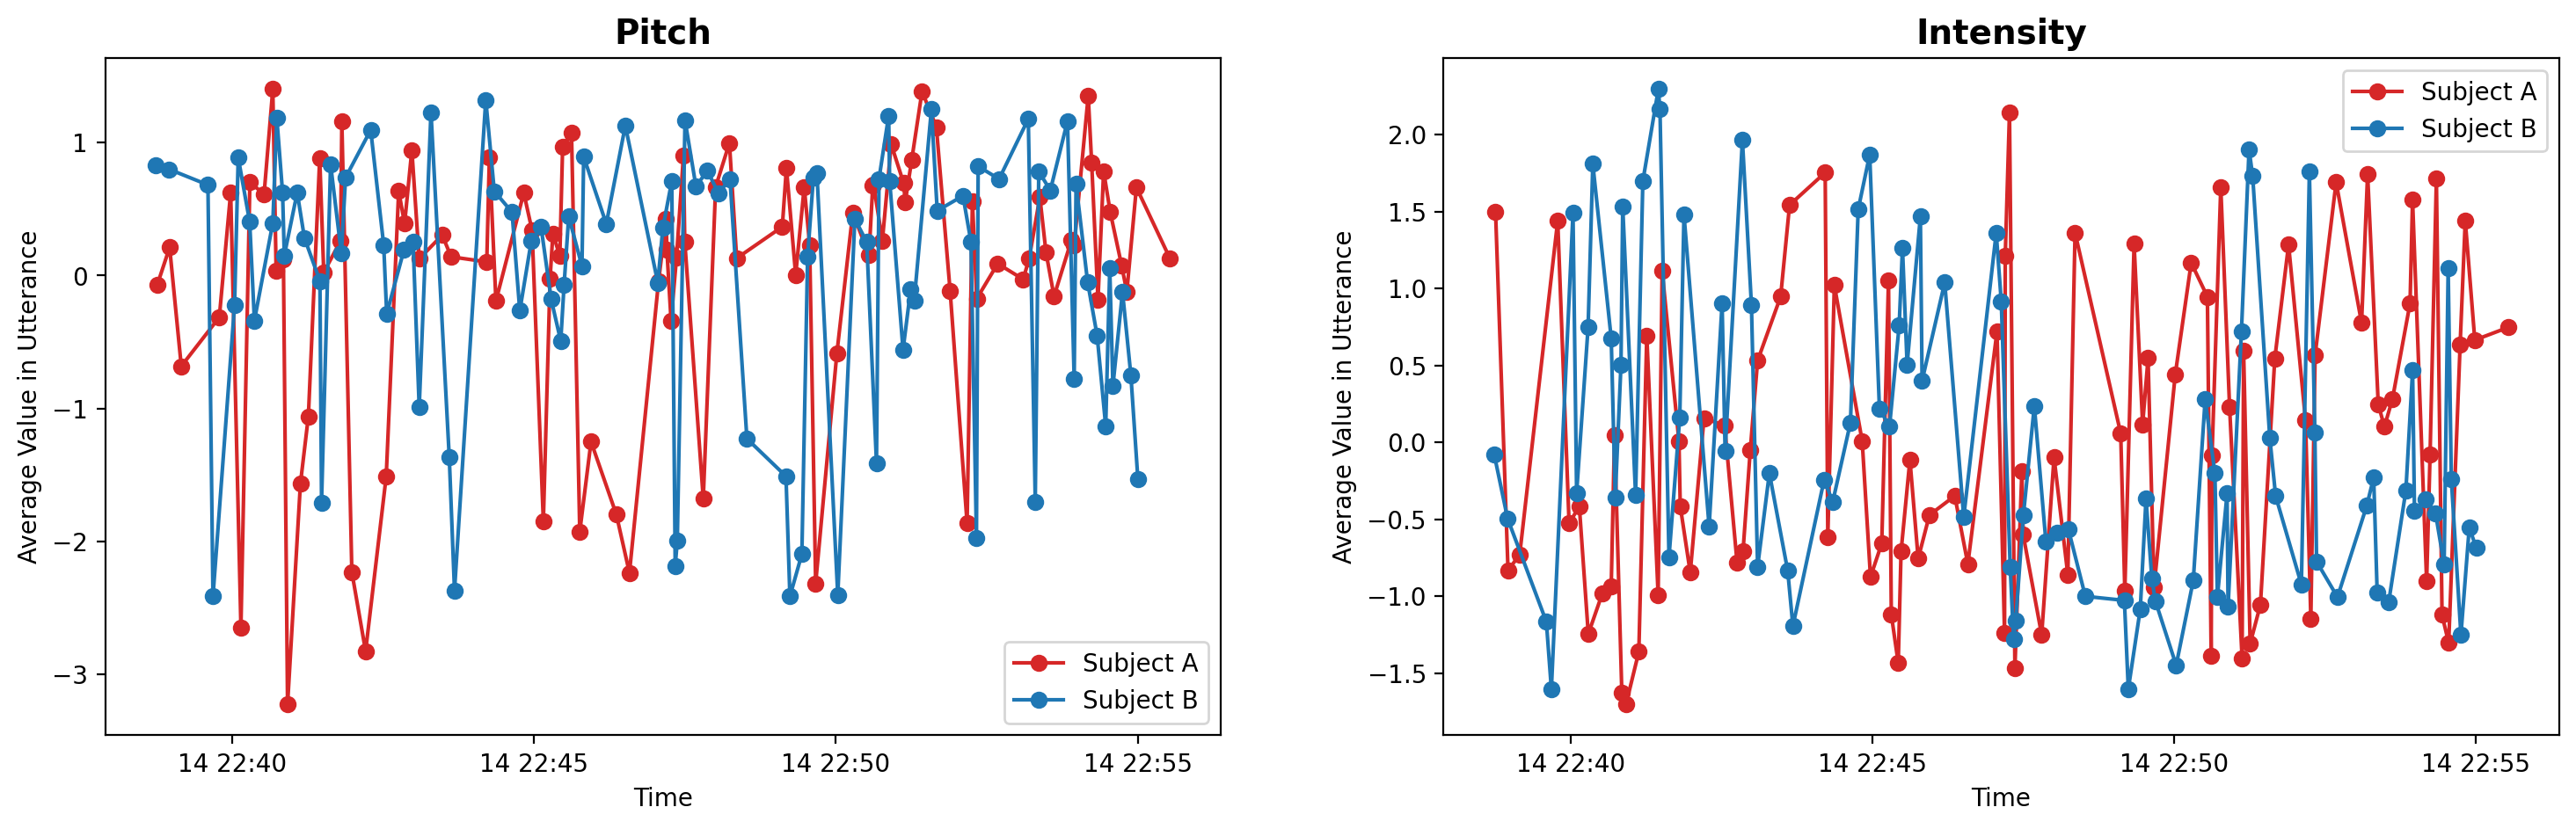

In [4]:
trial = Trial.from_directory("../data/study-3_2022/T000745/")
vocalics_component = VocalicsComponent.from_vocalics(trial.vocalics, 
                                                     segmentation_method=SegmentationMethod.KEEP_ALL)

fig, axs = plt.subplots(1, 2, figsize=(18,5))
vocalics_component.plot_features(axs, 1020, True, True)

## Discrete Coordination Inference

### Phase Coordination

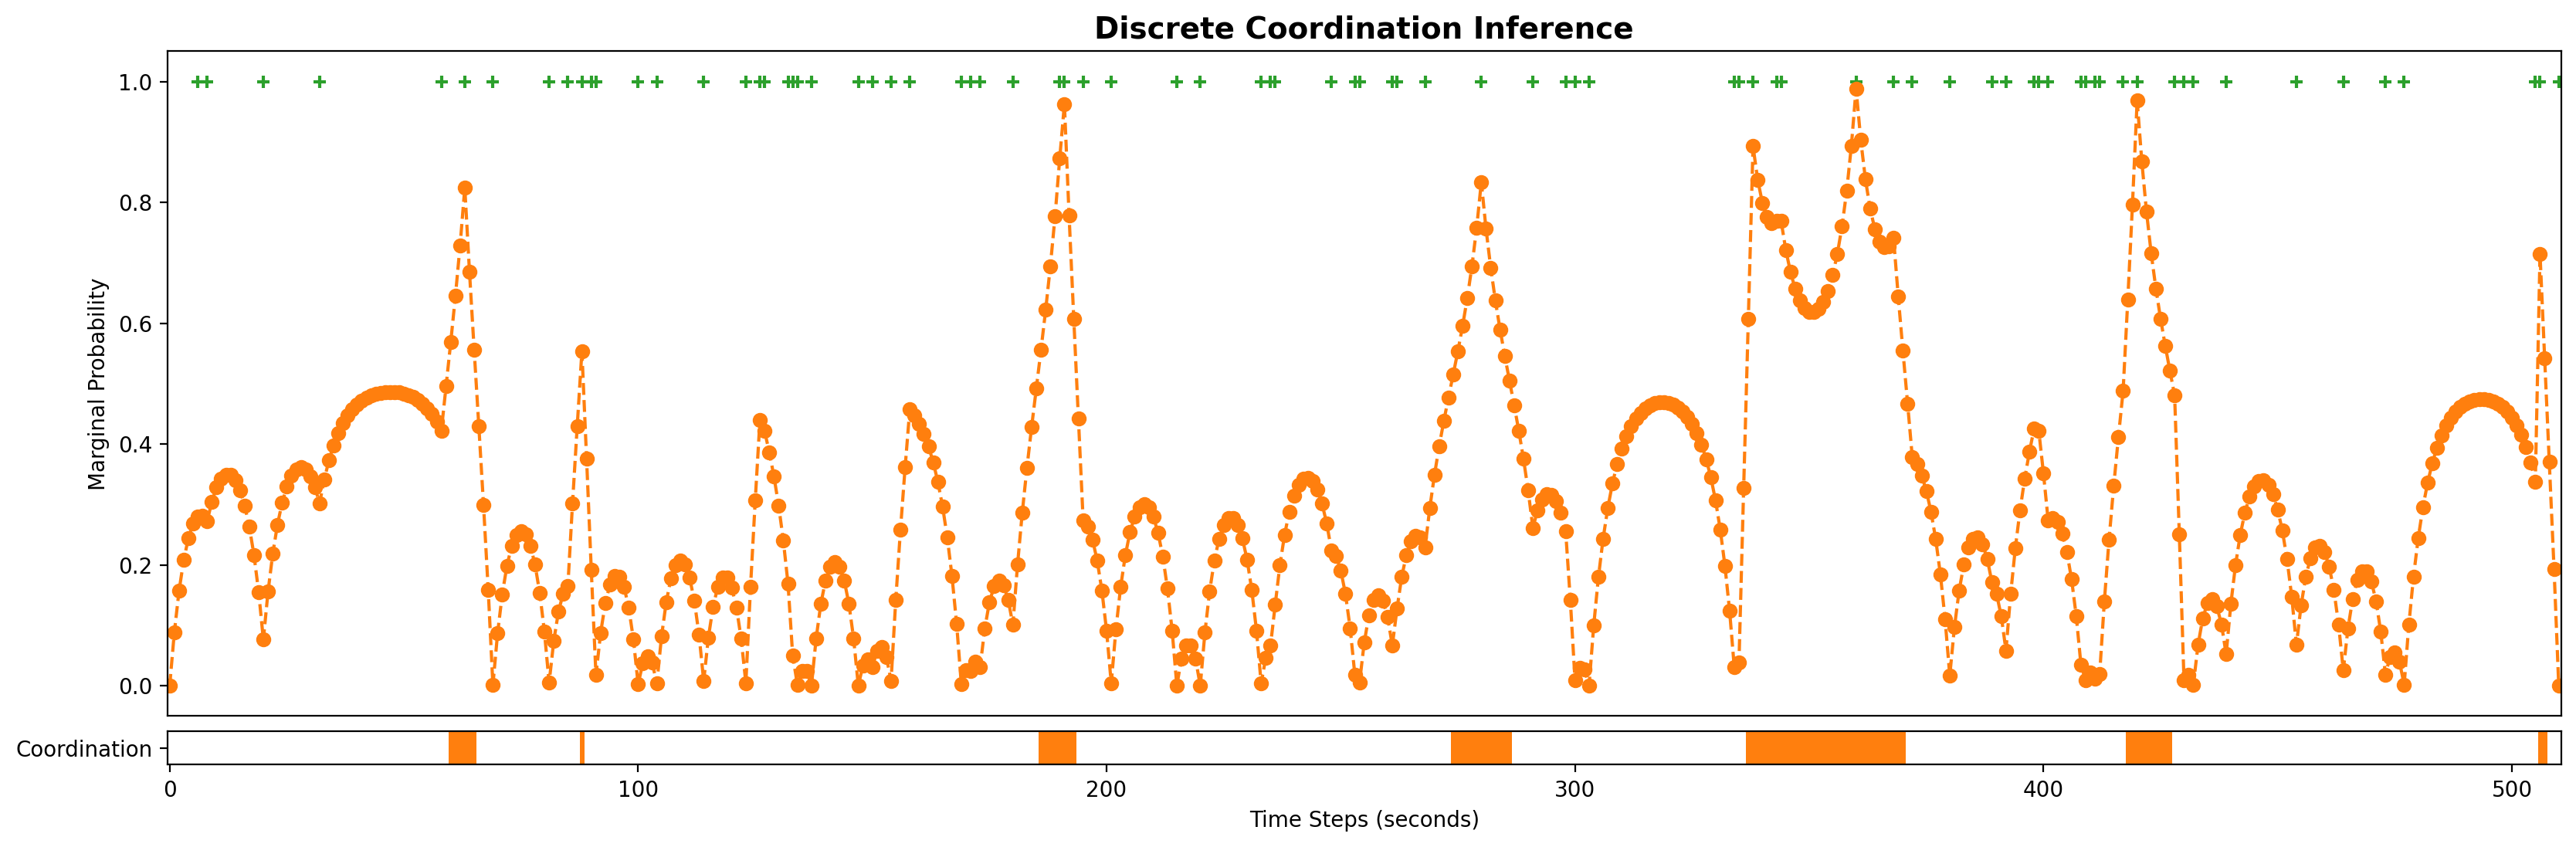

In [28]:
vocalics_a, vocalics_b = vocalics_component.sparse_series(NUM_TIME_STEPS, trial.metadata.mission_start)
vocalics_a.normalize()
vocalics_b.normalize()

inference_engine = DiscreteCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                             series_b=vocalics_b, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_a=MEAN_PRIOR_A,
                                                             mean_prior_b=MEAN_PRIOR_B,
                                                             std_prior_a=STD_PRIOR_A,
                                                             std_prior_b=STD_PRIOR_B,
                                                             std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                             std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                             std_coordinated_a=STD_COORDINATED_A,
                                                             std_coordinated_b=STD_COORDINATED_B)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Anti-Phase Coordination

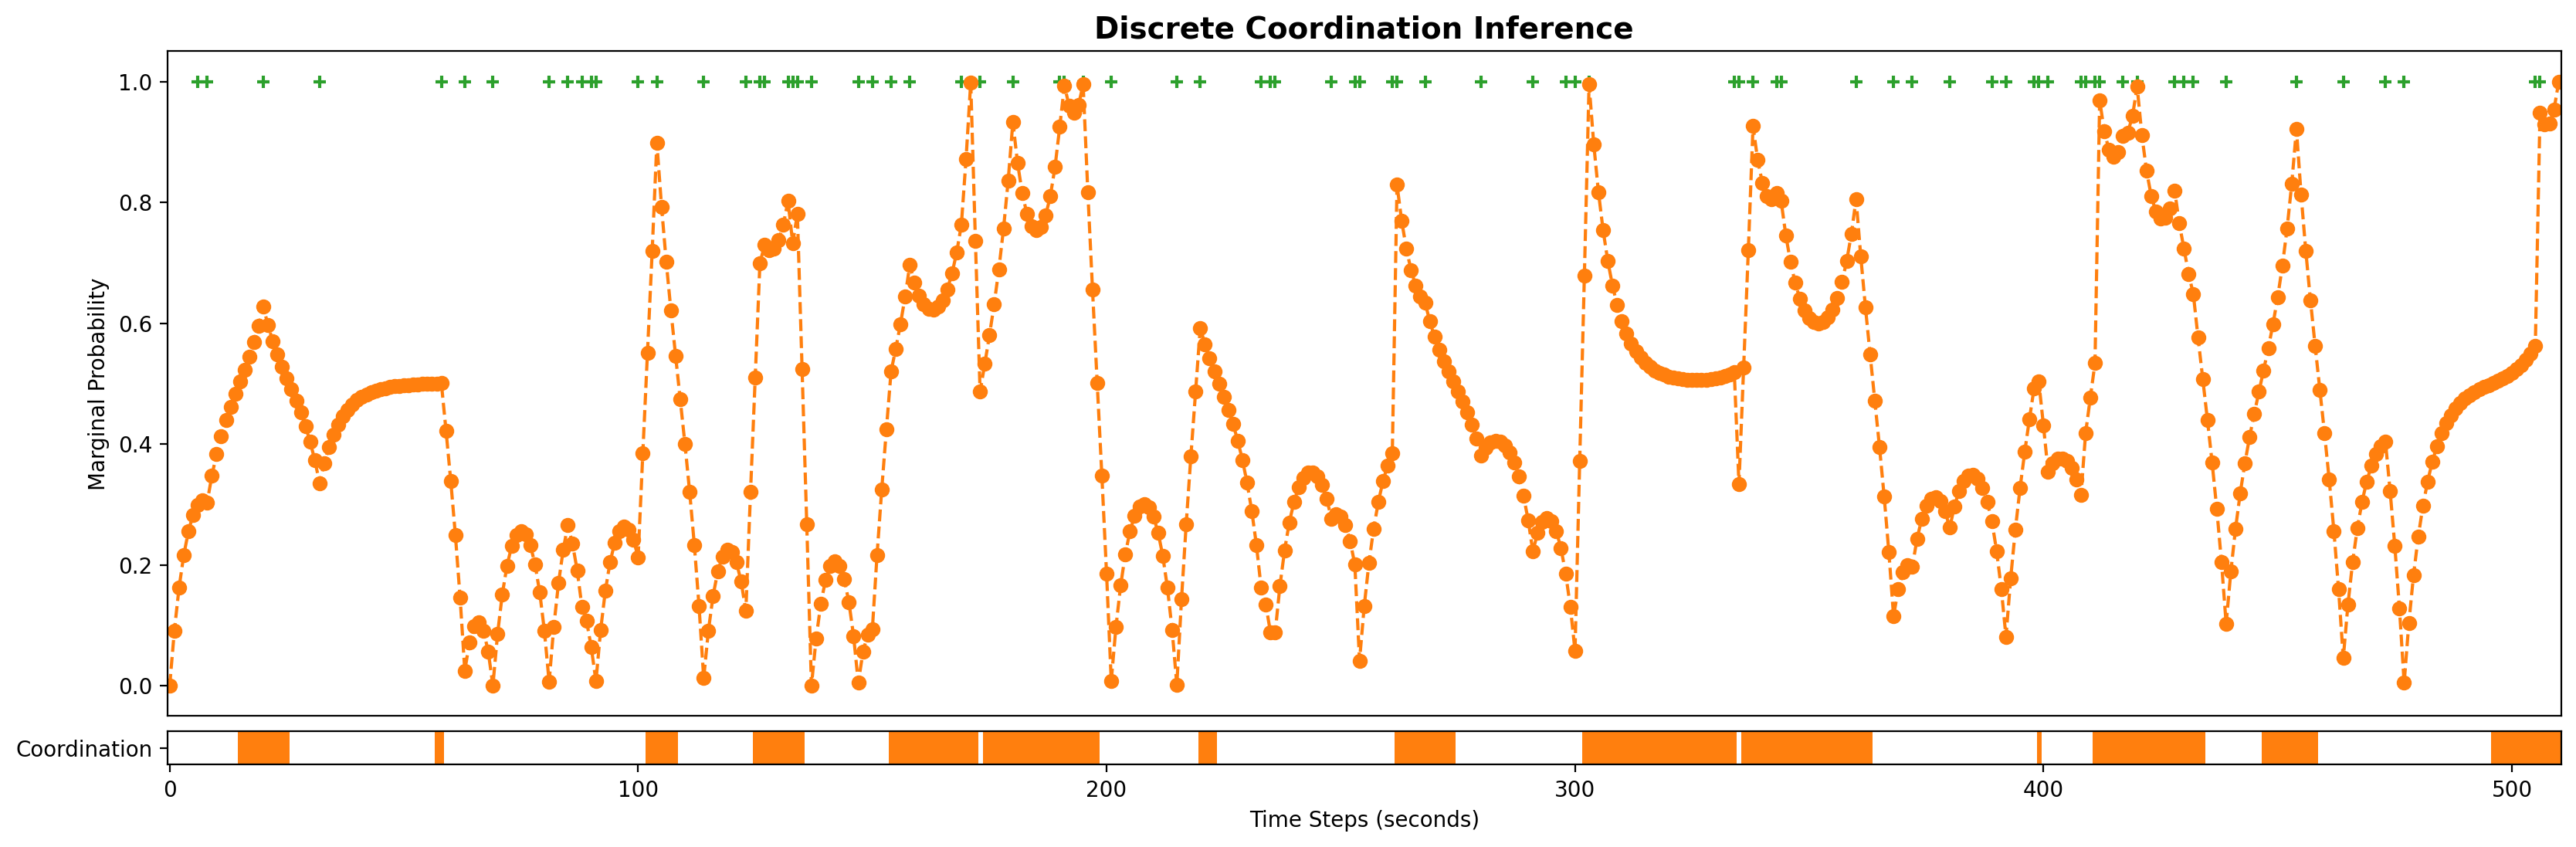

In [17]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(series_a=vocalics_a,
                                                             series_b=vocalics_b, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION, 
                                                             mean_prior_a=MEAN_PRIOR_A,
                                                             mean_prior_b=MEAN_PRIOR_B,
                                                             std_prior_a=STD_PRIOR_A,
                                                             std_prior_b=STD_PRIOR_B,
                                                             std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                             std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                             std_coordinated_a=STD_COORDINATED_A,
                                                             std_coordinated_b=STD_COORDINATED_B,
                                                             f=ANTIPHASE_FUNCTION)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Any-Phase Coordination

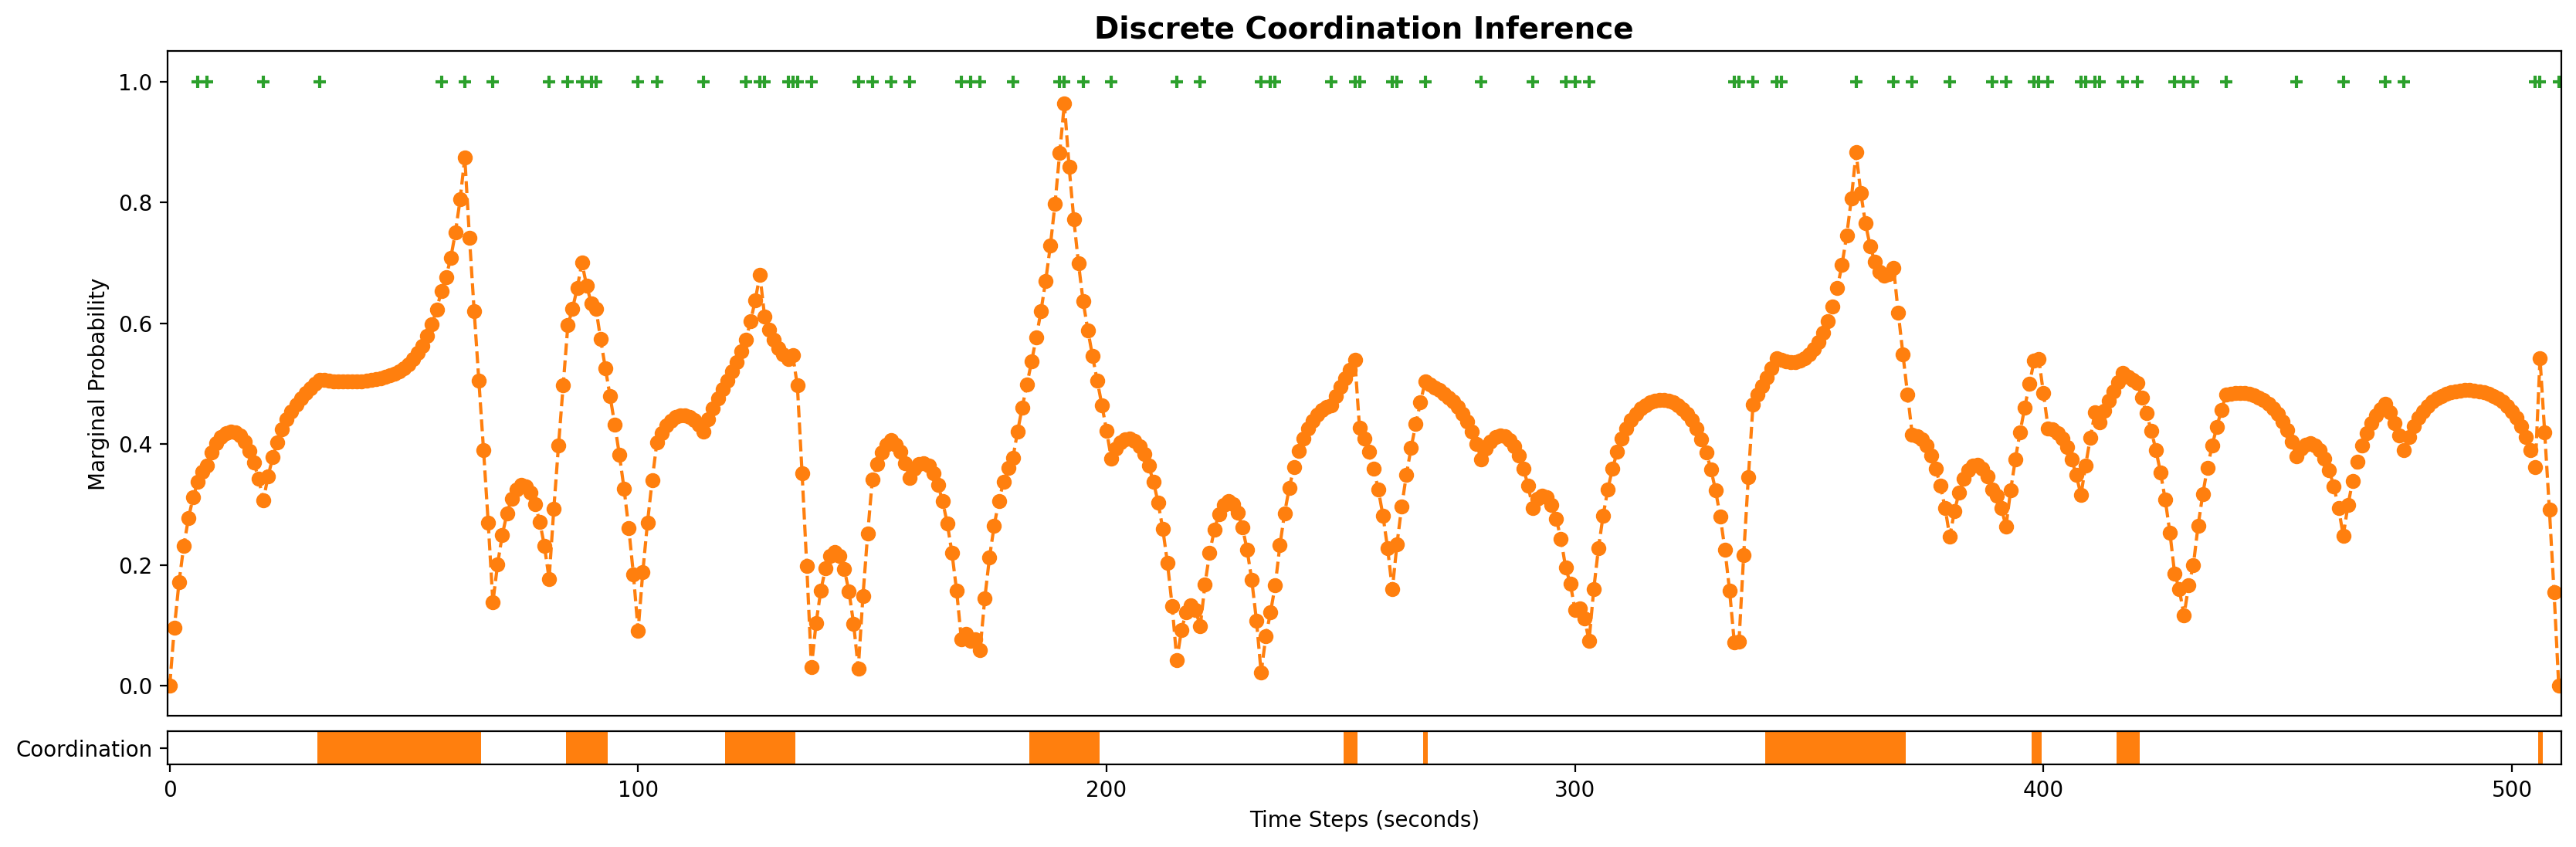

In [18]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(series_a=vocalics_a,
                                                             series_b=vocalics_b, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION, 
                                                             mean_prior_a=MEAN_PRIOR_A,
                                                             mean_prior_b=MEAN_PRIOR_B,
                                                             std_prior_a=STD_PRIOR_A,
                                                             std_prior_b=STD_PRIOR_B,
                                                             std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                             std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                             std_coordinated_a=STD_COORDINATED_A,
                                                             std_coordinated_b=STD_COORDINATED_B,
                                                             f=ANYPHASE_FUNCTION)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

## Continuous Coordination Inference

### Phase Coordination

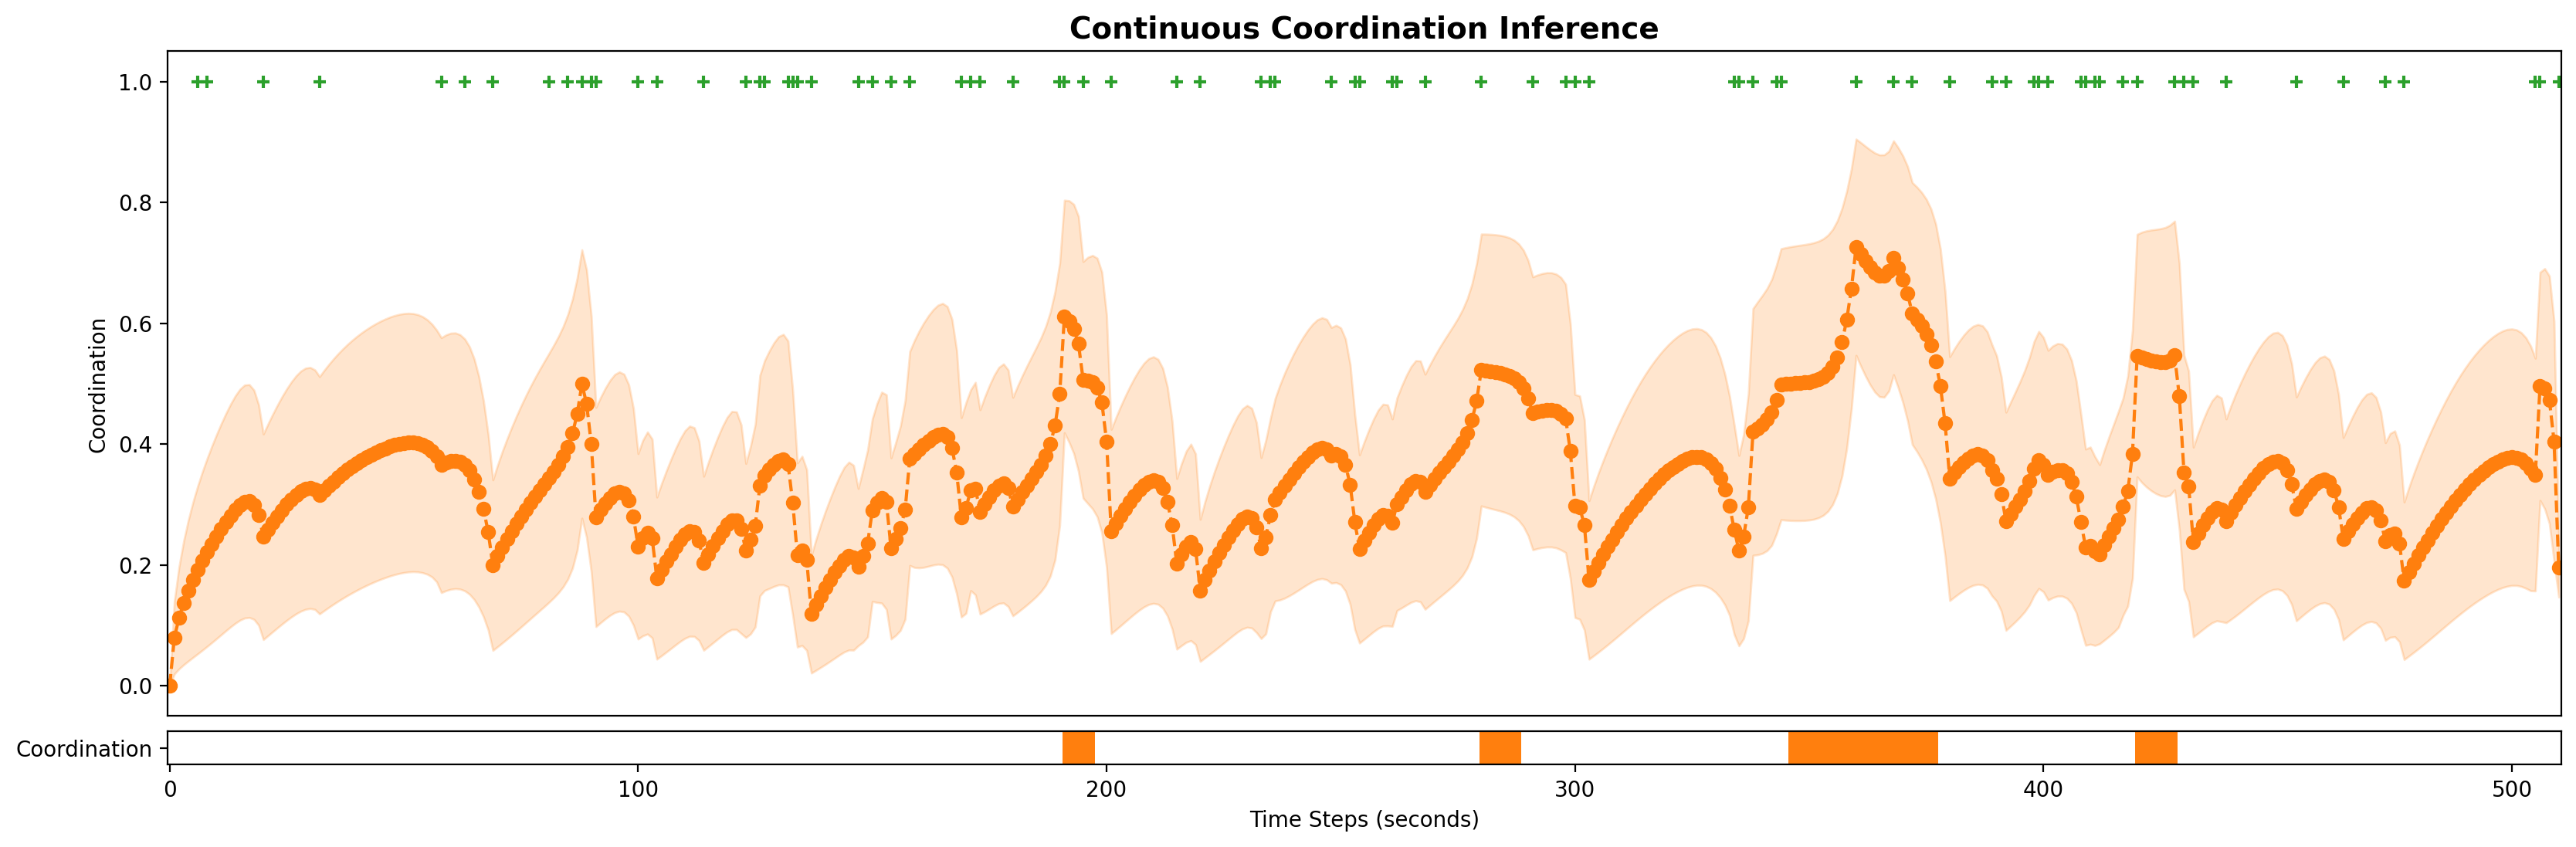

In [30]:
inference_engine = ContinuousCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                               series_b=vocalics_b, 
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_a=MEAN_PRIOR_A,
                                                               mean_prior_b=MEAN_PRIOR_B,
                                                               std_prior_a=STD_PRIOR_A,
                                                               std_prior_b=STD_PRIOR_B,
                                                               std_coupling_a=STD_COUPLING_A,
                                                               std_coupling_b=STD_COUPLING_B)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

#### Coordination Change Report

In [34]:
trial_audio = TrialAudio(trial.metadata, "/Users/paulosoares/data/study-3_2022/audio")
audio_component = VocalicsComponentAudio.from_vocalics_component(trial_audio, vocalics_component)
audio_a, audio_b = audio_component.sparse_series(NUM_TIME_STEPS, trial.metadata.mission_start)
report = CoordinationAbruptChangeReport(mean_cs, vocalics_a, vocalics_b, audio_a, audio_b, "Trial: T00045")
report.export_to_html("../data/study-3_2022/T000745/coordination_change/continuous_in_phase_report.html", 0.0)

### Anti-Phase Coordination

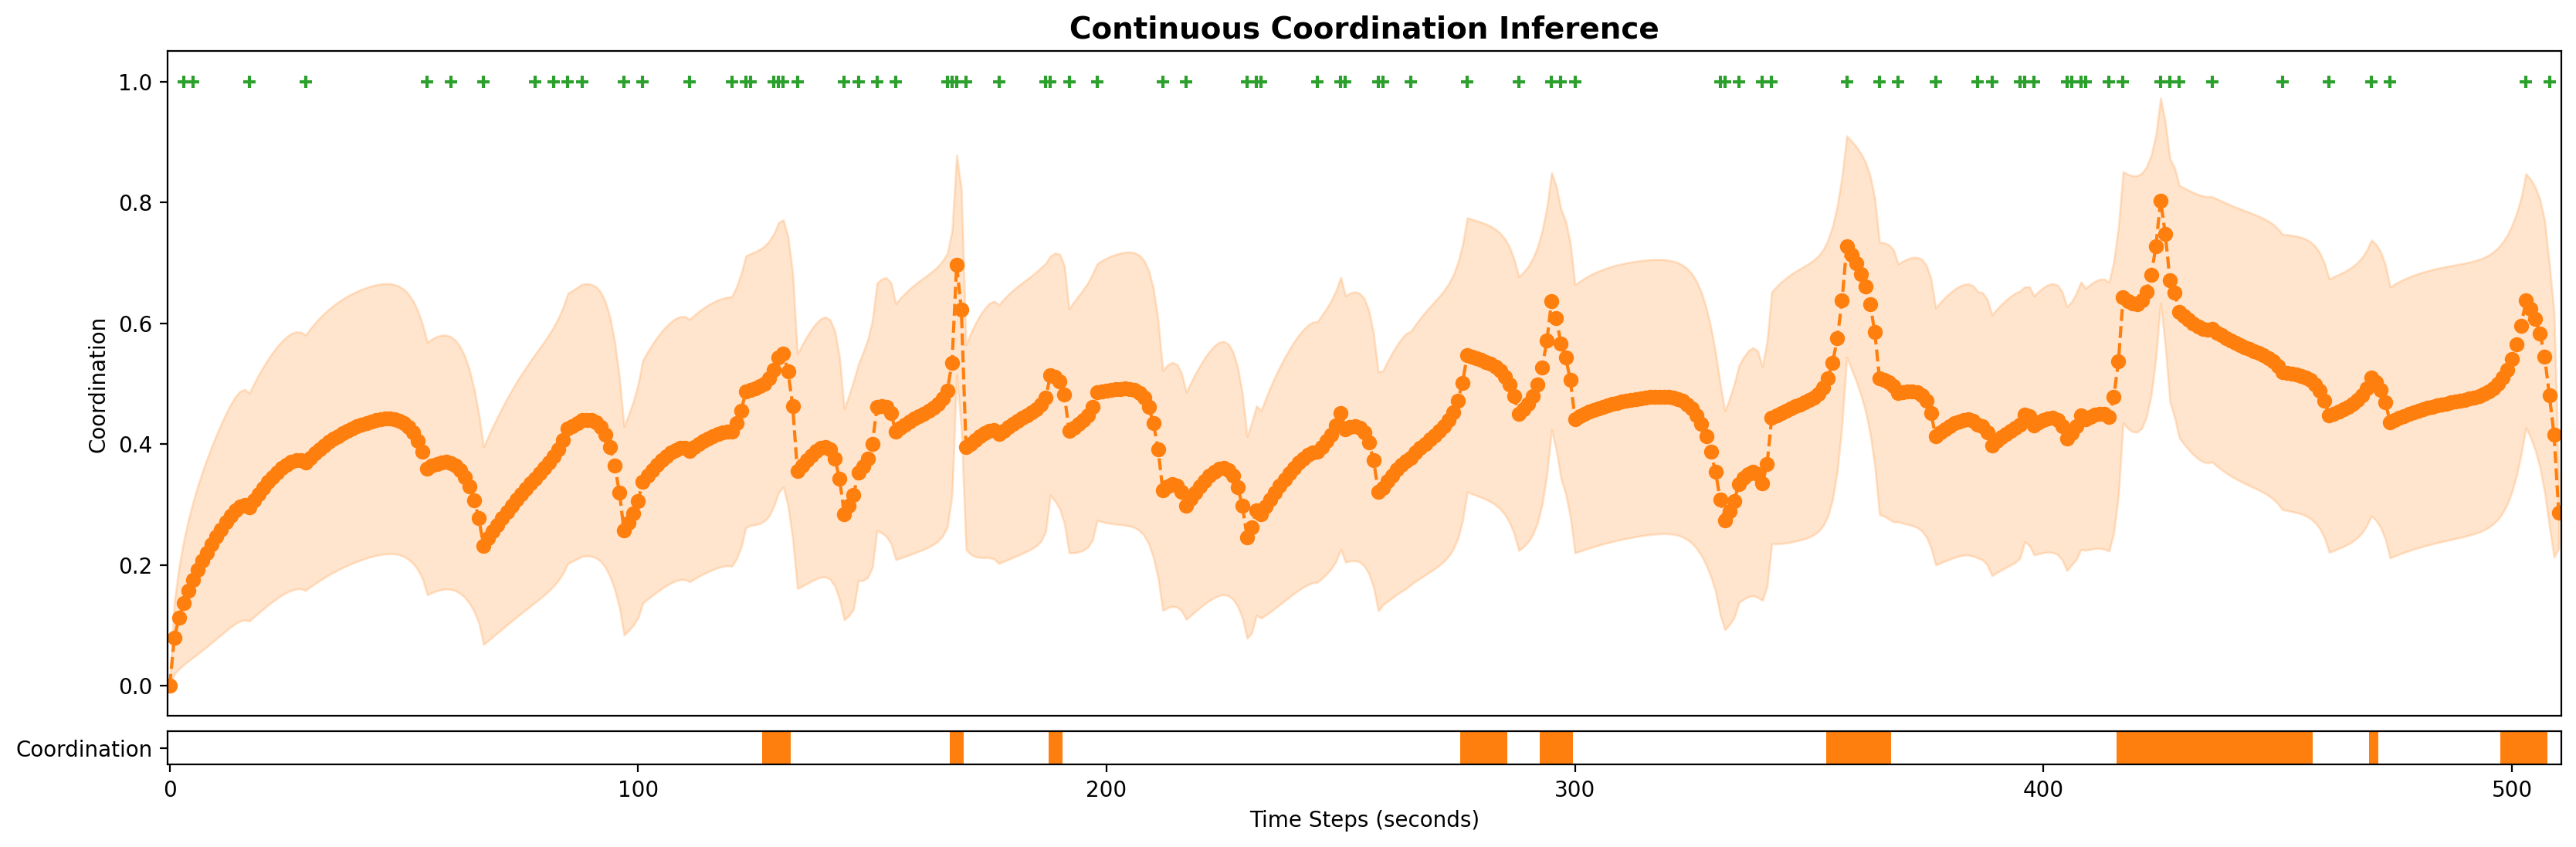

In [58]:
inference_engine = ContinuousCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                               series_b=vocalics_b, 
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR, 
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_a=MEAN_PRIOR_A,
                                                               mean_prior_b=MEAN_PRIOR_B,
                                                               std_prior_a=STD_PRIOR_A,
                                                               std_prior_b=STD_PRIOR_B,
                                                               std_coupling_a=STD_COUPLING_A,
                                                               std_coupling_b=STD_COUPLING_B,
                                                               f = ANTIPHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Any-phase Coordination

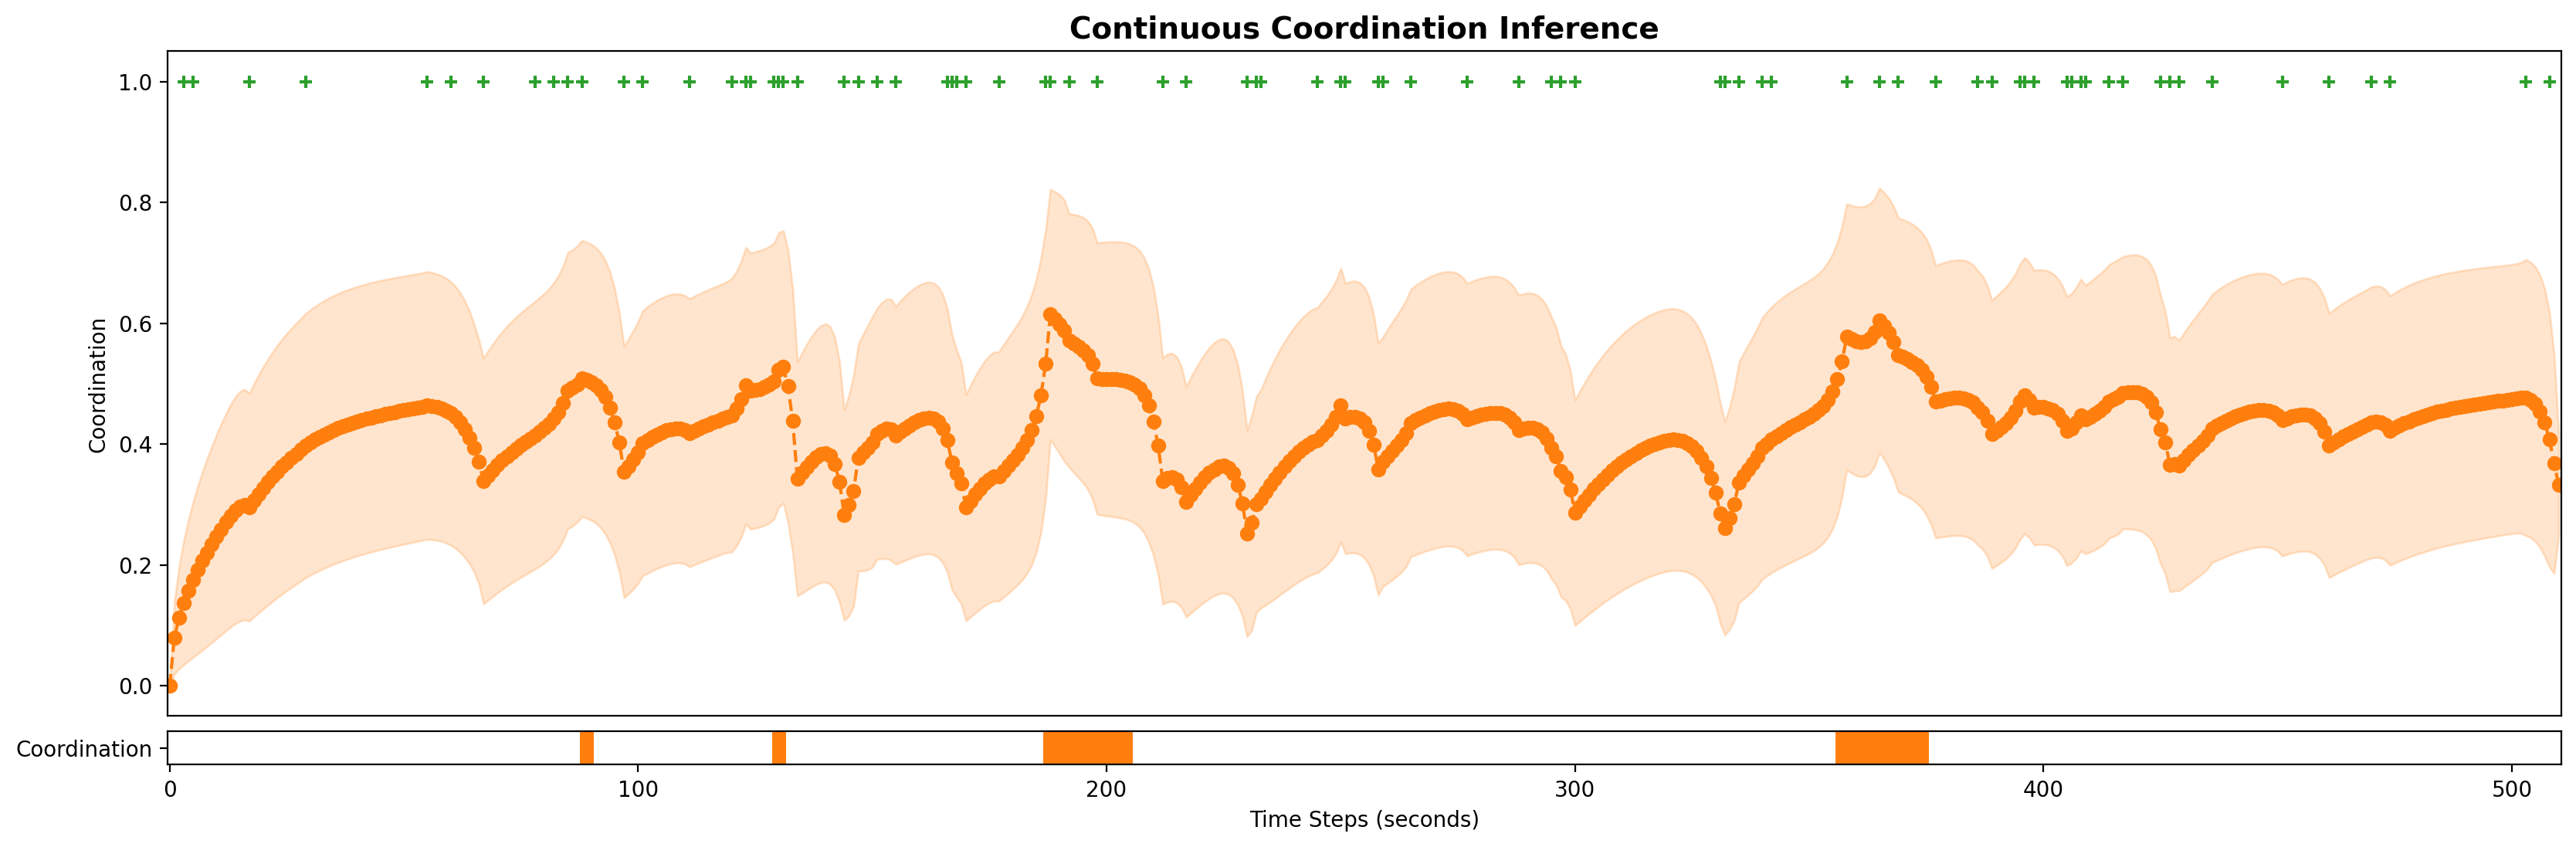

In [59]:
inference_engine = ContinuousCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                               series_b=vocalics_b, 
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR, 
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_a=MEAN_PRIOR_A,
                                                               mean_prior_b=MEAN_PRIOR_B,
                                                               std_prior_a=STD_PRIOR_A,
                                                               std_prior_b=STD_PRIOR_B,
                                                               std_coupling_a=STD_COUPLING_A,
                                                               std_coupling_b=STD_COUPLING_B,
                                                               f = ANYPHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
masks = np.bitwise_or(vocalics_a.mask.astype(bool),vocalics_b.mask.astype(bool))
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(masks) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])